In [4]:
import cv2
import numpy as np
import pandas as pd
import pickle as cPickle
from matplotlib import pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score,confusion_matrix,multilabel_confusion_matrix,recall_score
from sklearn.preprocessing import normalize
from sklearn import svm
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import time

## Environment setup

In [2]:
train_images_filenames = cPickle.load(open('resources/train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('resources/test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('resources/train_labels.dat','rb'))
test_labels = cPickle.load(open('resources/test_labels.dat','rb'))

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
SIFTdetector = cv2.SIFT_create(nfeatures=300)

In [5]:
def compute_dense_sift(gray,sift,step):
    step_size = step
    kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                        for x in range(0, gray.shape[1], step_size)]
    dense_feat = sift.compute(gray, kp)
    dense_feat_des = dense_feat[1]
    return dense_feat_des

In [7]:
def get_pyramid_image_cells(image,level):
    # CURRENTLY WORKING ONLY FOR LEVELS 0,1,2 (1,4, and 16 cells)
    M = (image.shape[0])//(level+1)
    N = (image.shape[1])//(level+1)
    tiles = [image[x:x+M,y:y+N] for x in range(0,image.shape[0],M) for y in range(0,image.shape[1],N)]
#     print(image.shape)
#     print("level=", level)
#     print("returning " + str(len(tiles)) + " tiles")
    return tiles

"""
for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    break

tiles = get_pyramid_image_cells(gray,2)
"""

'\nfor filename,labels in zip(train_images_filenames,train_labels):\n    ima=cv2.imread(filename)\n    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)\n    break\n\ntiles = get_pyramid_image_cells(gray,2)\n'

## Tweaking parameters for SVM with GridSearchCV Cross Validation

In [9]:
step=5

today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(f"{dt_string} started doing step={step}")

Train_descriptors = []
Train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
#     kpt,des=SIFTdetector.detectAndCompute(gray,None)
    des=compute_dense_sift(gray,SIFTdetector, step)
    Train_descriptors.append(des)
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)

k=128
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in range(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1))

# knn = KNeighborsClassifier(n_neighbors=37,n_jobs=-1,metric='manhattan')
# knn.fit(visual_words, train_labels)

today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(f"{dt_string} started doing step={step}")


12:39:12 started doing step=5
12:46:24 started doing step=5


In [11]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0,.001,.003,.01,.03,.1,.3,1,1.5],
                     'C': [1, 10, 100, 1000, 2000, 3000, 5000]},
                    {'kernel': ['linear'], 'C': [i for i in range(1,20,1)]}]

scores = ['precision_macro', 'recall_macro','accuracy']

today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(f"{dt_string} started doing step={step}")

data_results=[]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring=score
    )
    clf.fit(visual_words, train_labels)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        c=params['C']
        ker=params['kernel']
        if ker=='rbf': 
            gamma=params['gamma']
        else: gamma=None
            
        data_results.append([mean,std,c,gamma,ker,score])
        
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

#     print("Detailed classification report:")
#     print()
#     print("The model is trained on the full development set.")
#     print("The scores are computed on the full evaluation set.")
#     print()
#     y_true, y_pred = y_test, clf.predict(X_test)
#     print(classification_report(y_true, y_pred))
#     print()

today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(f"{dt_string} started doing step={step}")

12:49:13 started doing step=5
# Tuning hyper-parameters for precision_macro

Best parameters set found on development set:

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

Grid scores on development set:

0.019 (+/-0.000) for {'C': 1, 'gamma': 0, 'kernel': 'rbf'}
0.019 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.019 (+/-0.000) for {'C': 1, 'gamma': 0.003, 'kernel': 'rbf'}
0.387 (+/-0.139) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.696 (+/-0.167) for {'C': 1, 'gamma': 0.03, 'kernel': 'rbf'}
0.743 (+/-0.077) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.777 (+/-0.086) for {'C': 1, 'gamma': 0.3, 'kernel': 'rbf'}
0.791 (+/-0.064) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.795 (+/-0.074) for {'C': 1, 'gamma': 1.5, 'kernel': 'rbf'}
0.019 (+/-0.000) for {'C': 10, 'gamma': 0, 'kernel': 'rbf'}
0.390 (+/-0.140) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.691 (+/-0.157) for {'C': 10, 'gamma': 0.003, 'kernel': 'rbf'}
0.742 (+/-0.085) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0

Best parameters set found on development set:

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

Grid scores on development set:

0.155 (+/-0.002) for {'C': 1, 'gamma': 0, 'kernel': 'rbf'}
0.155 (+/-0.002) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.155 (+/-0.002) for {'C': 1, 'gamma': 0.003, 'kernel': 'rbf'}
0.397 (+/-0.021) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.684 (+/-0.097) for {'C': 1, 'gamma': 0.03, 'kernel': 'rbf'}
0.735 (+/-0.075) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.769 (+/-0.076) for {'C': 1, 'gamma': 0.3, 'kernel': 'rbf'}
0.784 (+/-0.056) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.787 (+/-0.068) for {'C': 1, 'gamma': 1.5, 'kernel': 'rbf'}
0.155 (+/-0.002) for {'C': 10, 'gamma': 0, 'kernel': 'rbf'}
0.399 (+/-0.017) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.684 (+/-0.090) for {'C': 10, 'gamma': 0.003, 'kernel': 'rbf'}
0.736 (+/-0.082) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.771 (+/-0.077) for {'C': 10, 'gamma': 0.03, 'kernel': 'rbf'}
0.791 (+/-0.069

In [92]:
df=pd.DataFrame(data_results, columns=['mean_val','std_val','c','gamma','ker','score'])

In [93]:
def plot_data(x,y,x_label, y_label, title):
    plt.title(title)
    plt.plot(x,y, marker='.')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
df

,mean_val,std_val,c,gamma,ker,score
0,0.019404,0.000151,1,0.000,rbf,precision_macro
1,0.019404,0.000151,1,0.001,rbf,precision_macro
2,0.019404,0.000151,1,0.003,rbf,precision_macro
3,0.387265,0.069563,1,0.010,rbf,precision_macro
4,0.696138,0.083304,1,0.030,rbf,precision_macro
...,...,...,...,...,...,...
241,0.783094,0.030349,15,NaN,linear,accuracy
242,0.782032,0.029606,16,NaN,linear,accuracy
243,0.780968,0.031310,17,NaN,linear,accuracy
244,0.781501,0.029807,18,NaN,linear,accuracy


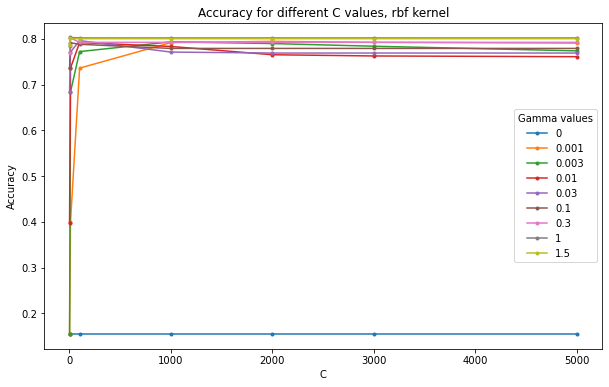

In [94]:
plt.figure(figsize=(10,6))
plt.title('Accuracy for different C values, rbf kernel')
for gamma_value in gamma_values:
    accuracy=rbf[(rbf.gamma==gamma_value)&(rbf.score=='accuracy')]['mean_val'].tolist()
    plt.plot(C_values_rbf,accuracy, marker='.',label=str(gamma_value))
    plt
    plt.xlabel('C')
    plt.ylabel('Accuracy')
plt.legend(title='Gamma values')
plt.show()

#### Showing details for combination of C=1000 and gamma=0.001

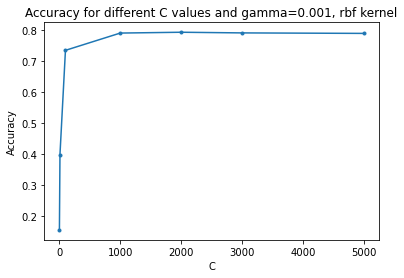

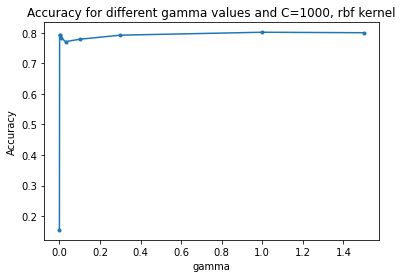

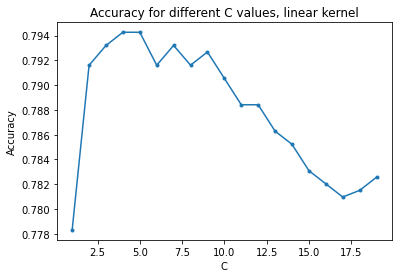

In [95]:
###### RBF KERNEL ###### 
rbf = df[(df.ker == 'rbf')]
# C VALUES: 4 data points
precision_c_values_rbf = rbf[(rbf.gamma==0.0010)&(rbf.score=='precision_macro')]['mean_val'].tolist()
recall_c_values_rbf = rbf[(rbf.gamma==0.0010)&(rbf.score=='recall_macro')]['mean_val'].tolist()
accuracy_c_values_rbf = rbf[(rbf.gamma==0.0010)&(rbf.score=='accuracy')]['mean_val'].tolist()


# GAMMA VALUES: 2 data points
precision_gamma_values_rbf = rbf[(rbf.c==1000)&(rbf.score=='precision_macro')]['mean_val'].tolist()
recall_gamma_values_rbf = rbf[(rbf.c==1000)&(rbf.score=='recall_macro')]['mean_val'].tolist()
accuracy_gamma_values_rbf = rbf[(rbf.c==1000)&(rbf.score=='accuracy')]['mean_val'].tolist()


###### LINEAR KERNEL ###### 
linear = df[(df.ker == 'linear')]
precision_c_values_linear = linear[(linear.score=='precision_macro')]['mean_val'].tolist()
recall_c_values_linear = linear[(linear.score=='recall_macro')]['mean_val'].tolist()
accuracy_c_values_linear = linear[(linear.score=='accuracy')]['mean_val'].tolist()

# PLOTS
# Precision - recall
#plot_data(recall_c_values_rbf,precision_c_values_rbf, 'Recall', 'Precision', 'precision-recall for C=[1,10,100,1000], rbf kernel')
#plot_data(recall_gamma_values_rbf,precision_gamma_values_rbf, 'Recall', 'Precision', 'precision-recall for gamma=[0.0010,0.0001], rbf kernel')
#plot_data(recall_c_values_linear,precision_c_values_linear, 'Recall', 'Precision', 'precision-recall for C=[1,10,100,1000], linear kernel')

# Accuracy
C_values_rbf=[1, 10, 100, 1000, 2000, 3000,5000]
C_values_linear=[i for i in range(1,20,1)]
gamma_values=[0,.001,.003,.01,.03,.1,.3,1,1.5]
plot_data(C_values_rbf,accuracy_c_values_rbf,'C','Accuracy','Accuracy for different C values and gamma=0.001, rbf kernel')
plot_data(gamma_values,accuracy_gamma_values_rbf,'gamma','Accuracy','Accuracy for different gamma values and C=1000, rbf kernel')
plot_data(C_values_linear,accuracy_c_values_linear,'C','Accuracy','Accuracy for different C values, linear kernel')



### Conclusion

Regularization parameter C, is defining a margin for error when dividing classes. The bigger the value the softer the margin

## Normalization and Scaler impact

#### Linear Kernel without scaler and without normalization

In [62]:
start = time.process_time()

lin_clf = svm.LinearSVC(max_iter=2000, C=10)
lin_clf.fit(visual_words, train_labels)

visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k).reshape(1,-1)

scores = cross_val_score(lin_clf, visual_words_test, test_labels, cv=5)
lin_accuracy_noNorm_noScaler=scores.mean()*100

end = time.process_time()
time_elapsed = end-start

print("Linear kernel without scaler without normalization accuracy: {}".format(lin_accuracy_noNorm_noScaler))

Linear kernel without scaler without normalization accuracy: 68.2762058124377


#### Linear Kernel without scaler with normalization (L1, L2, Max)

In [64]:
start = time.process_time()

lin_clf = svm.LinearSVC(max_iter=2000, C=10)
lin_clf.fit(visual_words, train_labels)

visual_words_test_L1=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_L2=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_Max=np.zeros((len(test_images_filenames),k),dtype=np.float32)

for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test_L1[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l1')
    visual_words_test_L2[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l2')
    visual_words_test_Max[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='max')

scores_L1 = cross_val_score(lin_clf, visual_words_test_L1, test_labels, cv=5)
scores_L2 = cross_val_score(lin_clf, visual_words_test_L2, test_labels, cv=5)
scores_Max = cross_val_score(lin_clf, visual_words_test_Max, test_labels, cv=5)

lin_accuracy_L1norm_noScaler=scores_L1.mean()*100
lin_accuracy_L2norm_noScaler=scores_L2.mean()*100
lin_accuracy_Maxnorm_noScaler=scores_Max.mean()*100

end = time.process_time()
time_elapsed = end-start

print("Linear kernel without scaler with normalization \n\tL1-norm accuracy: {} \n\tL2-norm accuracy: {} \n\tMax-norm accuracy: {}".format(lin_accuracy_L1norm_noScaler, lin_accuracy_L2norm_noScaler, lin_accuracy_Maxnorm_noScaler))

Linear kernel without scaler with normalization 
	L1-norm accuracy: 76.70500728471742 
	L2-norm accuracy: 73.8539989264627 
	Max-norm accuracy: 71.74909899547582


#### Linear kernel with scaler with normalization (L1, L2, Max)

In [63]:
start = time.process_time()

scaler = StandardScaler()
scaler.fit_transform(visual_words)

lin_clf = svm.LinearSVC(max_iter=2000, C=10)
lin_clf.fit(visual_words, train_labels)

visual_words_test_L1=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_L2=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_Max=np.zeros((len(test_images_filenames),k),dtype=np.float32)

for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test_L1[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l1')
    visual_words_test_L2[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l2')
    visual_words_test_Max[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='max')

visual_words_test_L1=scaler.transform(visual_words_test_L1)
visual_words_test_L2=scaler.transform(visual_words_test_L2)
visual_words_test_Max=scaler.transform(visual_words_test_Max)


scores_L1 = cross_val_score(lin_clf, visual_words_test_L1, test_labels, cv=5)
scores_L2 = cross_val_score(lin_clf, visual_words_test_L2, test_labels, cv=5)
scores_Max = cross_val_score(lin_clf, visual_words_test_Max, test_labels, cv=5)


lin_accuracy_L1norm_scaler=scores_L1.mean()*100
lin_accuracy_L2norm_scaler=scores.mean()*100
lin_accuracy_Maxnorm_scaler=scores.mean()*100


end = time.process_time()
time_elapsed = end-start


print("Linear kernel with scaler with normalization \n\tL1-norm accuracy: {} \n\tL2-norm accuracy: {} \n\tMax-norm accuracy: {}".format(lin_accuracy_L1norm_scaler, lin_accuracy_L2norm_scaler, lin_accuracy_Maxnorm_scaler))

Linear kernel with scaler with normalization 
	L1-norm accuracy: 71.37336093857833 
	L2-norm accuracy: 68.2762058124377 
	Max-norm accuracy: 68.2762058124377


#### Linear kernel with scaler without normalization

In [65]:
start = time.process_time()

scaler = StandardScaler()
scaler.fit_transform(visual_words)

lin_clf = svm.LinearSVC(max_iter=2000, C=10)
lin_clf.fit(visual_words, train_labels)

visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k).reshape(1,-1)

visual_words_test=scaler.transform(visual_words_test)
scores = cross_val_score(lin_clf, visual_words_test, test_labels, cv=5)
lin_accuracy_noNorm_scaler=scores.mean()*100


end = time.process_time()
time_elapsed = end-start

print("Linear kernel with scaler without normalization accuracy: {}".format(lin_accuracy_noNorm_scaler))

Linear kernel with scaler without normalization accuracy: 67.16279426424354


#### RBF Kernel without scaler without normalization

In [66]:

start = time.process_time()

rbf_svc = svm.SVC(kernel='rbf', C=1000, gamma=0.001)
rbf_svc.fit(visual_words, train_labels)

visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k).reshape(1,-1)

scores = cross_val_score(rbf_svc, visual_words_test, test_labels, cv=5)

rbf_accuracy_noNorm_noScaler=scores.mean()*100

end = time.process_time()
time_elapsed = end-start

print("RBF kernel without scaler with normalization accuracy: {}".format(rbf_accuracy_noNorm_noScaler))

RBF kernel without scaler with normalization accuracy: 14.621578099838967


#### RBF Kernel without scaler with normalization (L1, L2, max)

In [67]:
start = time.process_time()

rbf_svc = svm.SVC(kernel='rbf', C=1000, gamma=0.001)
rbf_svc.fit(visual_words, train_labels)


visual_words_test_L1=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_L2=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_Max=np.zeros((len(test_images_filenames),k),dtype=np.float32)


for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test_L1[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l1')
    visual_words_test_L2[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l2')
    visual_words_test_Max[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='max')

scores_L1 = cross_val_score(lin_clf, visual_words_test_L1, test_labels, cv=5)
scores_L2 = cross_val_score(lin_clf, visual_words_test_L2, test_labels, cv=5)
scores_Max = cross_val_score(lin_clf, visual_words_test_Max, test_labels, cv=5)


rbf_accuracy_L1norm_noScaler=scores_L1.mean()*100
rbf_accuracy_L2norm_noScaler=scores.mean()*100
rbf_accuracy_Maxnorm_noScaler=scores.mean()*100


end = time.process_time()
time_elapsed = end-start

print("RBF kernel without scaler with normalization \n\tL1-norm accuracy: {} \n\tL2-norm accuracy: {} \n\tMax-norm accuracy: {}".format(rbf_accuracy_L1norm_noScaler, rbf_accuracy_L2norm_noScaler, rbf_accuracy_Maxnorm_noScaler))

RBF kernel without scaler with normalization 
	L1-norm accuracy: 76.70500728471742 
	L2-norm accuracy: 14.621578099838967 
	Max-norm accuracy: 14.621578099838967


#### RBF Kernel with scaler with normalization (L1, L2, Max)

In [68]:
start = time.process_time()

scaler = StandardScaler()
scaler.fit_transform(visual_words)

rbf_svc = svm.SVC(kernel='rbf', C=1000, gamma=0.001)
rbf_svc.fit(visual_words, train_labels)


visual_words_test_L1=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_L2=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_Max=np.zeros((len(test_images_filenames),k),dtype=np.float32)


for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test_L1[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l1')
    visual_words_test_L2[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l2')
    visual_words_test_Max[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='max')

visual_words_test_L1=scaler.transform(visual_words_test_L1)
visual_words_test_L2=scaler.transform(visual_words_test_L2)
visual_words_test_Max=scaler.transform(visual_words_test_Max)

scores_L1 = cross_val_score(lin_clf, visual_words_test_L1, test_labels, cv=5)
scores_L2 = cross_val_score(lin_clf, visual_words_test_L2, test_labels, cv=5)
scores_Max = cross_val_score(lin_clf, visual_words_test_Max, test_labels, cv=5)


rbf_accuracy_L1norm_scaler=scores_L1.mean()*100
rbf_accuracy_L2norm_scaler=scores.mean()*100
rbf_accuracy_Maxnorm_scaler=scores.mean()*100


end = time.process_time()
time_elapsed = end-start

print("RBF kernel with scaler with normalization \n\tL1-norm accuracy: {} \n\tL2-norm accuracy: {} \n\tMax-norm accuracy: {}".format(rbf_accuracy_L1norm_scaler, rbf_accuracy_L2norm_scaler, rbf_accuracy_Maxnorm_scaler))

RBF kernel with scaler with normalization 
	L1-norm accuracy: 71.24837052373285 
	L2-norm accuracy: 14.621578099838967 
	Max-norm accuracy: 14.621578099838967


#### RBF Kernel with scaler without normalization

In [69]:
start = time.process_time()

scaler = StandardScaler()
scaler.fit_transform(visual_words)

rbf_svc = svm.SVC(kernel='rbf', C=1000, gamma=0.001)
rbf_svc.fit(visual_words, train_labels)

visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k).reshape(1,-1)

visual_words_test=scaler.transform(visual_words_test)

scores = cross_val_score(rbf_svc, visual_words_test, test_labels, cv=5)

rbf_accuracy_noNorm_noScaler=scores.mean()*100

end = time.process_time()
time_elapsed = end-start

print("RBF kernel without scaler with normalization accuracy: {}".format(rbf_accuracy_noNorm_noScaler))

RBF kernel without scaler with normalization accuracy: 14.621578099838967


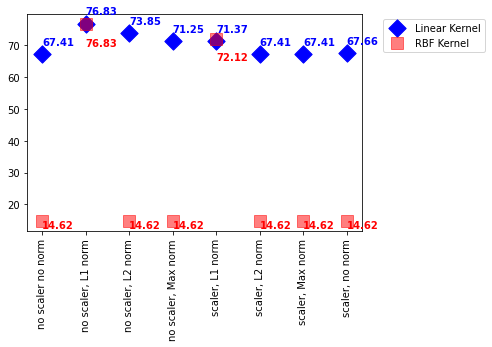

In [5]:
with open('scale_norm_data.pkl','rb') as f:
    data=cPickle.load(f)
    
lin_data = []
rbf_data = []

lin_data = data[0]
rbf_data = data[1]

categories = ["no scaler no norm", "no scaler, L1 norm", "no scaler, L2 norm", "no scaler, Max norm", "scaler, L1 norm", "scaler, L2 norm", "scaler, Max norm", "scaler, no norm"]

fig = plt.figure()
ax = fig.add_subplot(111)
plt.xticks(rotation=90, ha="center")
# plt.scatter(categories, lin_data)

ax.scatter(categories, lin_data, s=150, c='b', marker="D", alpha=1, label='Linear Kernel')
ax.scatter(categories, rbf_data, s=150, c='r', marker="s", alpha=0.5,  label='RBF Kernel')



plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));

idx = 0

for i, txt in enumerate(lin_data[0]):
    lin_txt = "{:.2f}".format(txt)
    rbf_txt = "{:.2f}".format(rbf_data[0][i])
    ax.annotate(lin_txt, (i, 1.03*lin_data[0][i]), ha='left', va='bottom', c='b',weight='bold', size=10)
    ax.annotate(rbf_txt, (i, 0.92*rbf_data[0][i]), ha='left', va='center', c='r',weight='bold', size=10)

plt.show()

### Conclusion

As we can see the L1 norm performs best regardless of a scaler 

## Sift density step impact on results in SVM

In [16]:
def calculate_vis(step):
    step=step

    today = datetime.now()
    dt_string = today.strftime("%H:%M:%S")
    print(f"{dt_string} started doing step={step}")

    Train_descriptors = []
    Train_label_per_descriptor = []

    for filename,labels in zip(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    #     kpt,des=SIFTdetector.detectAndCompute(gray,None)
        des=compute_dense_sift(gray,SIFTdetector, step)
        Train_descriptors.append(des)
        Train_label_per_descriptor.append(labels)

    D=np.vstack(Train_descriptors)

    k=128
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D)

    visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
    for i in range(len(Train_descriptors)):
        words=codebook.predict(Train_descriptors[i])
        visual_words[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1))

    # knn = KNeighborsClassifier(n_neighbors=37,n_jobs=-1,metric='manhattan')
    # knn.fit(visual_words, train_labels)

    today = datetime.now()
    dt_string = today.strftime("%H:%M:%S")
    print(f"{dt_string} started doing step={step}")
    
    scaler = StandardScaler()
    scaler.fit_transform(visual_words)
    
    lin_clf = svm.LinearSVC(max_iter=2000, C=10)
    lin_clf.fit(visual_words, train_labels)
    
    rbf_svc = svm.SVC(kernel='rbf', C=1000, gamma=0.001)
    rbf_svc.fit(visual_words, train_labels)

    visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
    for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    #     kpt,des=SIFTdetector.detectAndCompute(gray,None)
        des=compute_dense_sift(gray,SIFTdetector, step)
        words=codebook.predict(des)
        visual_words_test[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1))

    visual_words_test=scaler.transform(visual_words_test)
    
    scores = cross_val_score(lin_clf, visual_words_test, test_labels, cv=5)
    accuracy_linear=scores.mean()*100

    print("linear=",accuracy_linear)

    scores = cross_val_score(rbf_svc, visual_words_test, test_labels, cv=5)
    accuracy_rbf=scores.mean()*100

    print("rbf=",accuracy_rbf)
    
    return accuracy_linear,accuracy_rbf


In [ ]:
data_results_step =[]
steps_to_do=[5,20,50,100,300,500]
for step in steps_to_do:
    accuracy_linear,accuracy_rbf=calculate_vis(step)
    data_results_step.append([step,accuracy_linear,accuracy_rbf,1,1])
    
df=pd.DataFrame(data_results_step, columns=['step','accuracy_linear','accuracy_rbf','normalized','scaler'])    

In [85]:
with open('Different_densities_analysis.pkl','rb') as f:
    df=cPickle.load(f)

max for rbf
    step  accuracy_linear  accuracy_rbf  normalized  scaler  accuracy_inter
0     5        65.548654     78.937198           1       1         80.1756
max for linear
    step  accuracy_linear  accuracy_rbf  normalized  scaler  accuracy_inter
0     5        65.548654     78.937198           1       1         80.1756
max for inter
    step  accuracy_linear  accuracy_rbf  normalized  scaler  accuracy_inter
0     5        65.548654     78.937198           1       1         80.1756


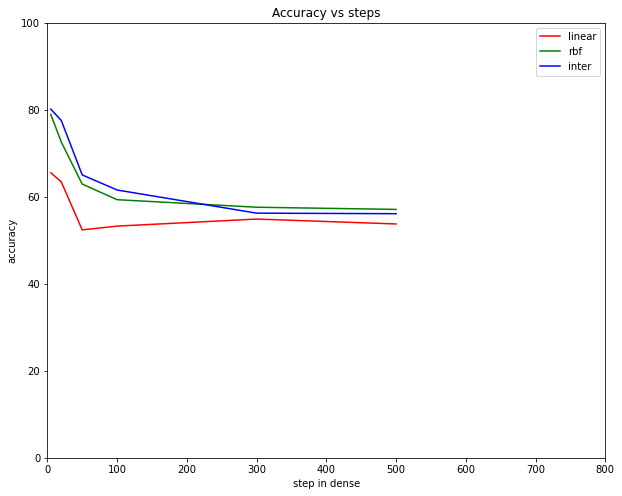

In [90]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set(title='Accuracy vs steps', xlim=(0,800), ylim=(0,100))
df2=df
y_rbf=df2.accuracy_rbf
y_lin=df2.accuracy_linear
y_inter=df2.accuracy_inter
print("max for rbf\n",df2[df2.accuracy_rbf==df2.accuracy_rbf.max()])
print("max for linear\n",df2[df2.accuracy_linear==df2.accuracy_linear.max()])
print("max for inter\n",df2[df2.accuracy_inter==df2.accuracy_inter.max()])
# print(df2[df2.recall==df2.recall.max()])

ax.plot(df2.step, y_lin, 'r', label='linear')
ax.plot(df2.step, y_rbf, 'g', label='rbf')
ax.plot(df2.step, y_inter, 'b', label='inter')
plt.xlabel('step in dense')
plt.ylabel('accuracy')
ax.legend()

### Conclusion on density versus kernel

We can notice that decreasing the density of SIFT is not improving the result of accuracy for SVM neither for Linear nor RBF kernel nor intersection histogram kernel. Best accuracy shows for step size equals to 5 in dense sift giving Linear accuracy of 66% and RBF accuracy of 79% and Intersection kernel of 80%.

Histogram intersection kernel performs better for smaller step size than 300 where it is crossing the line with with RBF kernel and starts performing worst.

In [88]:
df2

,step,accuracy_linear,accuracy_rbf,normalized,scaler,accuracy_inter
0,5,65.548654,78.937198,1,1,80.175600
1,20,63.446055,72.614063,1,1,77.567671
2,50,52.413159,62.947627,1,1,65.050226
3,100,53.275056,59.352810,1,1,61.581167
4,300,54.897631,57.619048,1,1,56.257189
5,500,53.771950,57.119086,1,1,56.129898


## Spatial Pyramids impact on SVM

In [ ]:
def create_pyramid_levels(pyramid):
    step=5

    today = datetime.now()
    dt_string = today.strftime("%H:%M:%S")
    print(f"{dt_string} started doing step={pyramid}")

    Train_descriptors = []
    Train_label_per_descriptor = []
    pyramid_levels = pyramid # level zero has 1 tile, level 1 has 4 tiles => 5 histograms that will be concatenated

    for filename,labels in zip(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        # break the image into pieces
        image_cells = []
        for i in range(pyramid_levels+1):

            level_cells = get_pyramid_image_cells(gray,level=i)
            image_cells = image_cells + level_cells
            # compute descriptors for each tile
        Train_descriptors_cell = []
        for cell in image_cells:
            des=compute_dense_sift(cell,SIFTdetector, step)
            Train_descriptors_cell.append(des)

        Train_descriptors.append(Train_descriptors_cell)
        Train_label_per_descriptor.append(labels)

    D=np.vstack([des for descriptors_cells in Train_descriptors for des in descriptors_cells])

    #codebook

    k=128
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D)

    #creating visual words for Training

    visual_words=np.zeros((len(Train_descriptors),k*21),dtype=np.float32)
    for idx,cells in enumerate(Train_descriptors):

        image_histograms = []
        for id2,image_cell in enumerate(cells):
            cell_words = codebook.predict(image_cell)
            image_histograms.append(normalize(np.bincount(cell_words,minlength=k).reshape(1,-1)))
            # concatenated histogram has k*(1+2**(2*pyramid_levels)) bins
            # normalize(np.bincount(words,minlength=k).reshape(1,-1))

        concatenated_histogram=image_histograms[0].copy()
        for cell_idx in range(1,len(image_histograms)):
            # concatenate histograms
            concatenated_histogram = np.concatenate((concatenated_histogram,image_histograms[cell_idx]))
        visual_words[idx,:]=concatenated_histogram.flatten()
        
    #PCA
    pca = PCA(n_components=(256))
    VWpca = pca.fit_transform(visual_words)

    #SVN kernels

    scaler = StandardScaler()
    scaler.fit_transform(VWpca)

    lin_clf = svm.LinearSVC(max_iter=2000, C=10)
    lin_clf.fit(VWpca, train_labels)

    rbf_svc = svm.SVC(kernel='rbf', C=1000, gamma=0.001)
    rbf_svc.fit(VWpca, train_labels)

    today = datetime.now()
    dt_string = today.strftime("%H:%M:%S")
    print(f"{dt_string} started doing test step={pyramid}")

    #creating SIFT descriptor

    Test_descriptors = []
    Test_label_per_descriptor = []
    # pyramid_levels = 1 # level zero has 1 tile, level 1 has 4 tiles => 5 histograms that will be concatenated
    for filename,labels in zip(test_images_filenames,test_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        # break the image into pieces
        image_cells = []
        for i in range(pyramid_levels+1):

            level_cells = get_pyramid_image_cells(gray,level=i)
            image_cells = image_cells + level_cells
            # compute descriptors for each tile
        Test_descriptors_cell = []
        for cell in image_cells:
            des=compute_dense_sift(cell,SIFTdetector, step)
            Test_descriptors_cell.append(des)

        Test_descriptors.append(Test_descriptors_cell)
        Test_label_per_descriptor.append(labels)

    #creating visual tests

    visual_words_test=np.zeros((len(Test_descriptors),k*21),dtype=np.float32)
    for idx,cells in enumerate(Test_descriptors):

        image_histograms = []
        for id2,image_cell in enumerate(cells):
            cell_words = codebook.predict(image_cell)
            image_histograms.append(normalize(np.bincount(cell_words,minlength=k).reshape(1,-1)))
            # concatenated histogram has k*(1+2**(2*pyramid_levels)) bins
            # normalize(np.bincount(words,minlength=k).reshape(1,-1))

        concatenated_histogram=image_histograms[0].copy()
        for cell_idx in range(1,len(image_histograms)):
            # concatenate histograms
            concatenated_histogram = np.concatenate((concatenated_histogram,image_histograms[cell_idx]))
        visual_words_test[idx,:]=concatenated_histogram.flatten()



    
    #PCA
    vwtestpca = pca.transform(visual_words_test)
    
    #scaler test
    visual_words_test=scaler.transform(vwtestpca)

    #accuracy for test linear
#     scores = cross_val_score(lin_clf, visual_words_test, test_labels, cv=5)
    scores = cross_val_score(lin_clf, vwtestpca, test_labels, cv=5)
    accuracy_linear=scores.mean()*100

    print("linear=",accuracy_linear)


    #accuracy for test rbf
    scores = cross_val_score(rbf_svc, visual_words_test, test_labels, cv=5)
    accuracy_rbf=scores.mean()*100

    print("rbf=",accuracy_rbf)

    return accuracy_linear,accuracy_rbf

In [ ]:
piramid=[2]
data_pyramid_levels=[]
for level in piramid:
    accuracy_linear,accuracy_rbf=create_pyramid_levels(level)
    data_pyramid_levels.append([level,5,accuracy_linear,accuracy_rbf,1,1])

df_level=pd.DataFrame(data_pyramid_levels, columns=['level','step','accuracy_linear','accuracy_rbf','normalized','scaler'])    

In [38]:
with open('Different_pyramid_all.pkl','rb') as f:
    df_all_pyramids=cPickle.load(f)

In [39]:
df_all_pyramids

,level,step,accuracy_linear,accuracy_rbf,normalized,scaler,pca
0,1,5,73.607852,80.790584,1,1,NaN
0,2,5,75.591596,76.207346,1,1,NaN
0,2,5,76.948854,58.490913,1,1,0.95
0,2,5,73.110191,72.613297,1,1,127.00


Level 1 of pyramid is: all image + 4 tiles

Level 2 of pyramid is: all image + 4 tiles + 16 tiles

Those calculations were running for more than 30min each so it was very hard to debug it many times in timely manner and run for multiple PCA values to find optimum but following best practice of 0.95 we can see that linear accuracy improves where RBF goes a lot worst.